# Arnold Tongue

In [3]:
import zipfile
import numpy as np
import os
# Path to the zipped 2D embedded data
zip_file_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/2dembedded_data.zip'
extraction_dir = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Space/temp_extraction'

# Extract zipped data to a temporary directory
with zipfile.ZipFile(zip_file_path, 'r') as zipf:
    zipf.extractall(extraction_dir)

eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']


# ODEINT

# BDF

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def kuramoto_model(t, theta, omega, K, N, y):
    """ Kuramoto model to describe synchronization phenomena.
    y is the driving force with amplitude a and frequency b.
    """
    dydt = omega + (K/N) * np.sum(np.sin(theta - theta[:, np.newaxis]), axis=1) + y(t)
    return dydt

def driving_force(t, a, b):
    """ Periodic driving force with amplitude 'a' and frequency 'b'. """
    return a * np.cos(2 * np.pi * b * t)

# Parameters
N = len(eeg_channels)  # Number of oscillators (one for each EEG channel)
K = 1.0  # Coupling strength
omega = np.random.uniform(-1, 1, N)  # Natural frequencies

# Ranges for amplitude 'a' and frequency 'b' of the driving force
a_values = np.linspace(0.1, 2.0, 50)
b_values = np.linspace(0.1, 2.0, 50)

# Store results
synchronization_array = np.zeros((len(a_values), len(b_values)))

# Iterate over values of a and b
for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        y = lambda t: driving_force(t, a, b)
        
        # Integrate the Kuramoto model with the given driving force using BDF method
        theta_0 = np.random.uniform(0, 2 * np.pi, N)
        T = [0, 100]
        solution = solve_ivp(kuramoto_model, T, theta_0, args=(omega, K, N, y), method='BDF', t_eval=np.linspace(0, 100, 1000))
        
        # Measure synchronization
        r = np.abs(np.sum(np.exp(1j * solution.y), axis=0)) / N
        synchronization_array[i, j] = np.mean(r)

# Plot
plt.imshow(synchronization_array, extent=[a_values.min(), a_values.max(), b_values.min(), b_values.max()], origin='lower', aspect='auto')
plt.colorbar(label="Synchronization")
plt.xlabel('Amplitude a')
plt.ylabel('Frequency b')
plt.title('Arnold Tongues')
plt.show()

# Extract and save features

In [ ]:
import numpy as np
import pandas as pd

# CNN Feature
cnn_feature = (synchronization_array - synchronization_array.min()) / (synchronization_array.max() - synchronization_array.min())

# RNN Feature
rnn_feature = cnn_feature  # We can directly use the same normalized data; during training, we would treat each row/column as a sequence.

# Save the features
save_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Features'
np.save(f"{save_path}/cnn_synch_array.npy", cnn_feature)
np.save(f"{save_path}/rnn_synch_array.npy", rnn_feature)

# Print shape and head
# For CNN feature
cnn_df = pd.DataFrame(cnn_feature)
print("\nCNN Feature Shape:")
print(cnn_df.shape)
print("\nCNN Feature Head:")
print(cnn_df.head())

# For RNN feature
rnn_df = pd.DataFrame(rnn_feature)
print("\nRNN Feature Shape:")
print(rnn_df.shape)
print("\nRNN Feature Head:")
print(rnn_df.head())


# Mode Locked

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from matplotlib.colors import LinearSegmentedColormap
from multiprocessing import Pool

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# Channel labels
eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Convert the EEG data to a dictionary
EEG_data_dict = {ch: EEG_data[:, i] for i, ch in enumerate(eeg_channels)}

# Extract the instantaneous phase from EEG data for each channel
instantaneous_phase_dict = {ch: np.angle(hilbert(data)) for ch, data in EEG_data_dict.items()}

# Compute average phase across channels for each time point
avg_phase = np.mean(list(instantaneous_phase_dict.values()), axis=0)

# Define the circle map
def circle_map(theta, Omega, K):
    return theta + Omega - K / (2 * np.pi) * np.sin(2 * np.pi * theta)


# Reduce the number of iterations for mode-locking checking for speed-up (can be adjusted)
ITERATIONS = 100

# Function to check mode-locking (revised to vectorize with numpy)
def is_mode_locked(theta, Omega, K, iterations=ITERATIONS, tol=1e-6):
    for _ in range(iterations):
        theta_next = circle_map(theta, Omega, K)
        if np.all(np.abs(theta_next - theta) < tol):
            return True
        theta = theta_next
    return False

# Function for mode-locking for a pair of Omega and K values
def mode_locking_for_pair(params):
    omega, K, phases = params
    locked_sum = 0
    for phase in phases:
        if is_mode_locked(phase, omega, K):
            locked_sum += 1
    return locked_sum / len(phases)

# Parameters
omegas = np.linspace(0, 1, 300)  # Omega values
K_values = np.linspace(0, 4 * np.pi, 300)  # K values

# Flatten the omega and K grid for parallel processing
omegas_grid, K_grid = np.meshgrid(omegas, K_values)
omegas_flat = omegas_grid.flatten()
K_flat = K_grid.flatten()

# Replicate the average phase for each pair of omega and K
phases_list = [avg_phase] * len(omegas_flat)

# Use multiprocessing pool to parallelize the calculation
with Pool() as pool:
    locked_flat = pool.map(mode_locking_for_pair, zip(omegas_flat, K_flat, phases_list))

# Using all available CPU cores for multiprocessing
num_cpus = cpu_count()

# Use multiprocessing pool to parallelize the calculation
with Pool(num_cpus) as pool:
    locked_flat = pool.map(mode_locking_for_pair, zip(omegas_flat, K_flat, phases_list))

# Reshape the locked_flat back to the grid shape
locked = np.array(locked_flat).reshape(omegas_grid.shape)

# Custom colormap
colors = [(1, 0, 1), (0, 0, 1)]  # R -> G -> B; Purple to Blue
cm = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Plotting
plt.figure(figsize=(10, 7))
plt.imshow(locked, extent=(omegas.min(), omegas.max(), K_values.min(), K_values.max()), aspect='auto', origin='lower', cmap=cm)
plt.colorbar(label='Proportion Mode-Locked')
plt.title('Arnold Tongues with EEG data')
plt.xlabel('Omega (Ω)')
plt.ylabel('K')

# Save the plot
plot_save_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Arnold Tongues/arnold_tongues_plot.png"
plt.savefig(plot_save_path)
print(f"Plot saved to {plot_save_path}")

# Show the plot
plt.show()

# Save the results to a .npy file
results_save_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Arnold Tongues/arnold_tongues_results.npy"
np.save(results_save_path, locked)
print(f"Results saved to {results_save_path}")

# Extract and save features

In [ ]:
import numpy as np
import pandas as pd

# Load the saved locked results
locked = np.load("/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Arnold Tongues/arnold_tongues_results.npy")

# Create normalized features from the locked results
# Normalize the locked data between 0 and 1 for neural network compatibility
normalized_locked = (locked - locked.min()) / (locked.max() - locked.min())

# CNN Feature
cnn_feature = normalized_locked

# RNN Feature
# Here we'll consider each row as a time series. 
# So the RNN feature would be a collection of time series.
rnn_feature = normalized_locked

# Save the features
save_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Features'
np.save(f"{save_path}/cnn_modelocked.npy", cnn_feature)
np.save(f"{save_path}/rnn_modelocked.npy", rnn_feature)

# Print shape and head
# For CNN feature
cnn_df = pd.DataFrame(cnn_feature)
print("\nCNN Feature Shape:")
print(cnn_df.shape)
print("\nCNN Feature Head:")
print(cnn_df.head())

# For RNN feature
rnn_df = pd.DataFrame(rnn_feature)
print("\nRNN Feature Shape:")
print(rnn_df.shape)
print("\nRNN Feature Head:")
print(rnn_df.head())

# Arnold tongues rotations

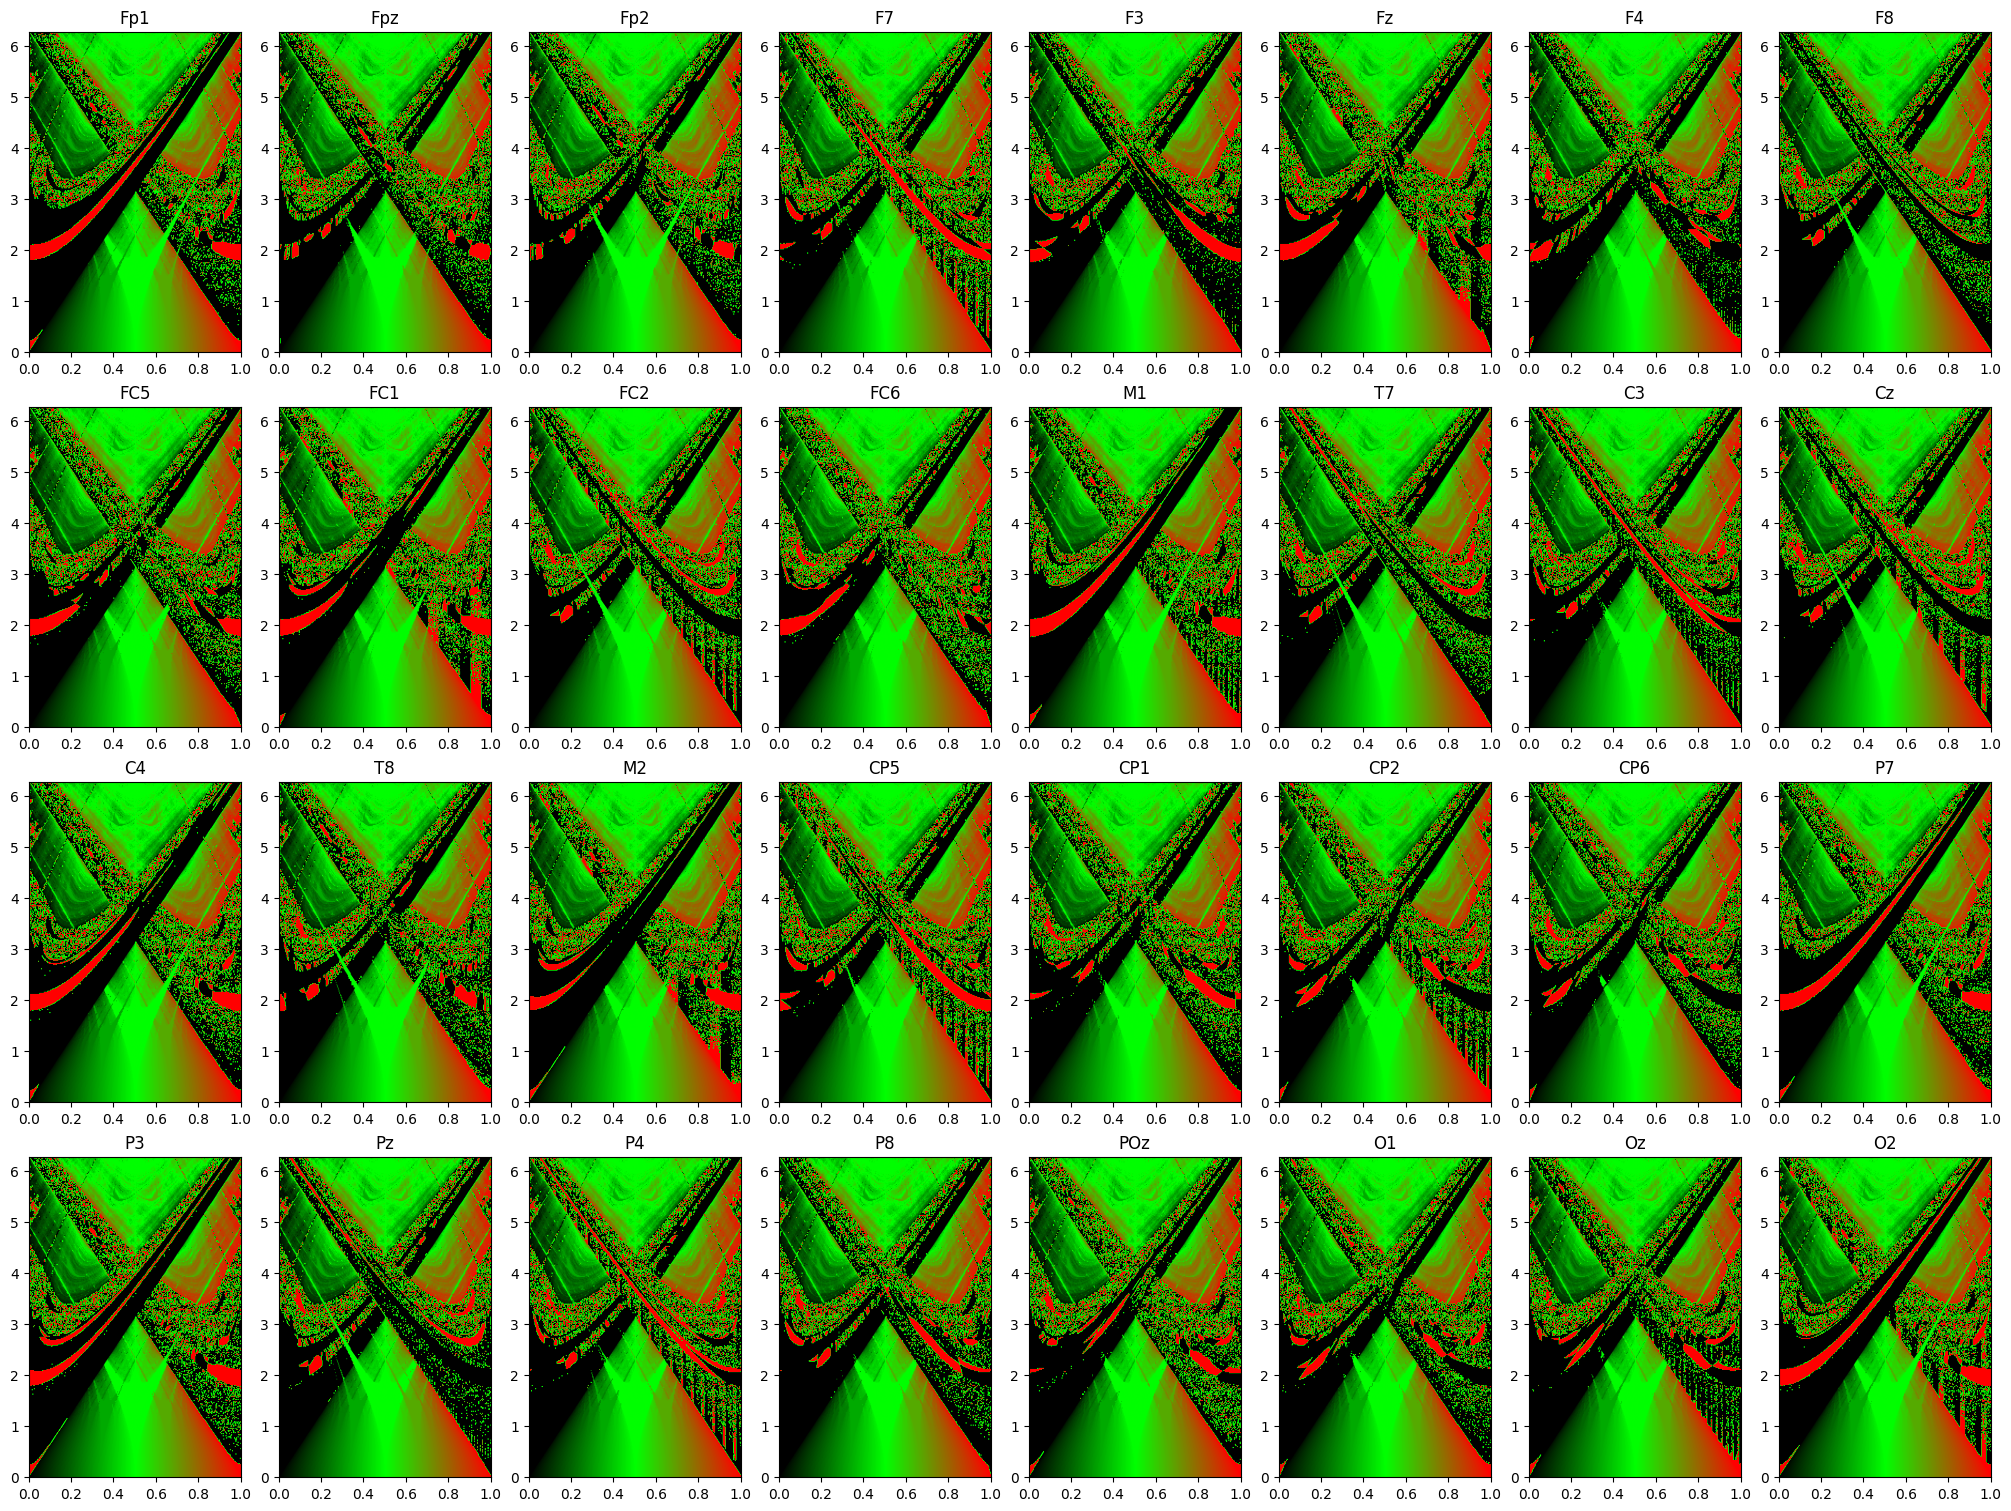

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# Channel labels
eeg_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Convert the EEG data to a dictionary
EEG_data_dict = {ch: EEG_data[:, i] for i, ch in enumerate(eeg_channels)}

# Define the circle map
def circle_map(theta, Omega, K):
    return theta + Omega - K / (2 * np.pi) * np.sin(2 * np.pi * theta)

# Compute average rotation number across all EEG channels
def average_rotation_number(omega, K, ch_data, iterations=1000, transient=100):
    theta = np.mean(ch_data)  # Use mean EEG value for initial condition
    for _ in range(transient):  # discard transient iterations
        theta = circle_map(theta, omega, K)

    diffs = []
    for _ in range(iterations):
        theta_next = circle_map(theta, omega, K)
        diffs.append(theta_next - theta)
        theta = theta_next
    return np.mean(diffs) % 1

# Parameters
omegas = np.linspace(0, 1, 300)
K_values = np.linspace(0, 2 * np.pi, 300)
rotation_numbers_dict = {}

# Compute rotation numbers for each channel
for ch, data in EEG_data_dict.items():
    rotation_numbers = np.zeros((len(K_values), len(omegas)))
    for i, K in enumerate(K_values):
        for j, omega in enumerate(omegas):
            rotation_numbers[i, j] = average_rotation_number(omega, K, data)
    rotation_numbers_dict[ch] = rotation_numbers

# Save rotation numbers
save_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Arnold Tongues/'
np.save(save_path + 'rotation_numbers.npy', rotation_numbers_dict)

# Define custom colormap
colors = [(0, 0, 0), (0, 1, 0), (1, 0, 0)]
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=256)

# Plotting
rows = 4
cols = 8
fig, axs = plt.subplots(rows, cols, figsize=(20, 15), constrained_layout=True)

for ax, (ch, rotation_numbers) in zip(axs.flat, rotation_numbers_dict.items()):
    ax.imshow(rotation_numbers, extent=(omegas.min(), omegas.max(), K_values.min(), K_values.max()), 
              aspect='auto', origin='lower', cmap=cmap, clim=(0, 1))
    ax.set_title(ch)

# Remove unused subplots (if any)
for idx in range(len(eeg_channels), rows * cols):
    axs.flat[idx].axis('off')

# Save the plot
plt.savefig(save_path + 'arnold_tongues_plot.png', dpi=300)
plt.show()


# Extract and save features

In [8]:
import numpy as np
import pandas as pd

# Load rotation numbers
rotation_numbers_dict = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Arnold Tongues/rotation_numbers.npy', allow_pickle=True).item()

# CNN Feature
# Convert the dictionary to a 3D array (channels x K_values x omegas)
cnn_features = np.array([rotation_numbers_dict[ch] for ch in eeg_channels])

# RNN Feature
# We consider each column in the rotation number for a channel as a time series, and we transpose for RNN input.
rnn_features = np.transpose(cnn_features, (0, 2, 1))

# Save the features
save_path = '/home/vincent/AAA_projects/MVCS/Neuroscience/Features'
np.save(f"{save_path}/cnn_arnold_tongues_rotations.npy", cnn_features)
np.save(f"{save_path}/rnn_arnold_tongues_rotations.npy", rnn_features)

# Print shape and head using pandas
# For CNN feature
cnn_df = pd.DataFrame(cnn_features.reshape(cnn_features.shape[0], -1))
print("\nCNN Feature Shape:")
print(cnn_df.shape)
print("\nCNN Feature Head:")
print(cnn_df.head())

# For RNN feature
rnn_df = pd.DataFrame(rnn_features.reshape(rnn_features.shape[0], -1))
print("\nRNN Feature Shape:")
print(rnn_df.shape)
print("\nRNN Feature Head:")
print(rnn_df.head())


CNN Feature Shape:
(32, 90000)

CNN Feature Head:
   0         1         2         3         4         5         6      \
0    0.0  0.003344  0.006689  0.010033  0.013378  0.016722  0.020067   
1    0.0  0.003344  0.006689  0.010033  0.013378  0.016722  0.020067   
2    0.0  0.003344  0.006689  0.010033  0.013378  0.016722  0.020067   
3    0.0  0.003344  0.006689  0.010033  0.013378  0.016722  0.020067   
4    0.0  0.003344  0.006689  0.010033  0.013378  0.016722  0.020067   

      7         8       9      ...  89990  89991  89992  89993  89994  89995  \
0  0.023411  0.026756  0.0301  ...    0.0    0.0    0.0    0.0    0.0    0.0   
1  0.023411  0.026756  0.0301  ...    0.0    0.0    0.0    0.0    0.0    0.0   
2  0.023411  0.026756  0.0301  ...    0.0    0.0    0.0    0.0    0.0    0.0   
3  0.023411  0.026756  0.0301  ...    0.0    0.0    0.0    0.0    0.0    0.0   
4  0.023411  0.026756  0.0301  ...    0.0    0.0    0.0    0.0    0.0    0.0   

   89996  89997  89998         8999

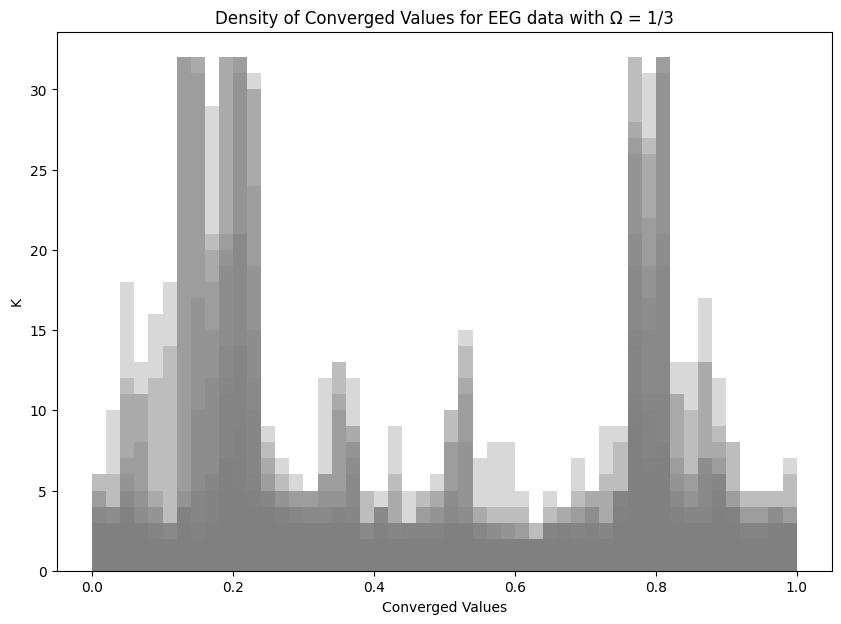

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Circle map function
def circle_map(theta, Omega, K):
    return theta + Omega - K / (2 * np.pi) * np.sin(2 * np.pi * theta)

# Parameters
Omega = 1/3
K_values = np.linspace(0, 4 * np.pi, 300)
iterations = 50

# For each channel, apply the circle map and store the results
all_hist_data = []

for channel in range(EEG_data.shape[0]):
    theta_values_init = EEG_data[channel]
    theta_values_init = (theta_values_init - np.min(theta_values_init)) / (np.max(theta_values_init) - np.min(theta_values_init))
    
    hist_data = []
    
    for K in K_values:
        theta_values = theta_values_init.copy()
        for _ in range(iterations):
            theta_values = circle_map(theta_values, Omega, K)
        hist_data.append(theta_values)

    # Convert to numpy array and adjust for desired plotting range
    hist_data = np.array(hist_data)
    hist_data = np.mod(hist_data, 1)
    all_hist_data.append(hist_data)

# Now, you can plot for each channel or derive some aggregate metric across all channels.
# As a simplistic approach, we'll just average across all channels for plotting.
avg_hist_data = np.mean(all_hist_data, axis=0)

# Directory to save the results and plots
save_directory = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Arnold Tongues"

# Save the averaged histogram data
np.save(os.path.join(save_directory, "avg_hist_data.npy"), avg_hist_data)

# Plotting
plt.figure(figsize=(10, 7))

# We can use the histogram approach to better visualize mode-locking behavior for each K value
for idx, K in enumerate(K_values):
    plt.hist(avg_hist_data[idx], bins=np.linspace(0, 1, 51), range=(0, 1), color='gray', alpha=0.3)

plt.title('Density of Converged Values for EEG data with Ω = 1/3')
plt.xlabel('Converged Values')
plt.ylabel('K')
# Save the plot
plt.savefig(os.path.join(save_directory, "Arnold_Tongues_Plot.png"))
plt.show()